In [16]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
gridX = loadRomsGrid(grdFile)

### Set file names
outFilePath='../data/proc/'



### Other run settings
runningLocation = 'local'
if  runningLocation== 'local':
    hisOSSEFilePath='../data/raw/newRepeat/'
    hisTruthFilePath='../data/raw/truth/final/' # Truth file settings
elif runningLocation == 'gdata':
    hisFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'
    truthFilePath='/g/data/fu5/deg581/EAC_2yr_ObsVerification_HighRes/output/' # Truth file settings

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'

loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [17]:
def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    err=err2**(1/2)
    output = indexMeanMetric(err,etaRange,xiRange)
    return err,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName


def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def addZDimension(ds):
    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta.fillna(0) * (1 + Zo_rho/ds.h) # replace nan values in zeta with 0
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta.fillna(0) + (ds.zeta.fillna(0) + ds.h) * Zo_rho
    ds.coords['z_rho'] = z_rho.transpose()   # needing transpose seems to be an xarray bug



In [18]:
from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds


In [19]:
def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

In [20]:
### Open truth file
OverlappedTruthFiles = 'yes'
if OverlappedTruthFiles == 'yes':
    truth_raw = loadOverlappedNetcdf(hisTruthFilePath,prefixTruth,filestring='080[0-7]*.nc',overlapDays=7)
elif OverlappedTruthFiles == 'no':
    import glob
    chunks = {'ocean_time':1}

    filelist = glob.glob(hisTruthFilePath+prefixTruth+'0800*.nc')
    #datelist = np.array(range(timeRange[0],timeRange[1],4))

    for files in filelist: 
        print(files)
        # filelist.append(files)
    truth = xr.open_mfdataset(filelist,chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right') 
    # truth = dropDuplicateTimes(truth)


loaded from ../data/raw/truth/final/outer_his_08001.nc to ../data/raw/truth/final/outer_his_08077.nc


In [21]:
osseAna_raw = loadOSSE(hisOSSEFilePath,prefixAnalysis,filestring='08*.nc',overlapDays=7)
osseFore_raw = loadOSSE(hisOSSEFilePath,prefixForecast,filestring='08*.nc',overlapDays=7)


loaded from ../data/raw/newRepeat/roms_fwd_outer1_08005.nc to ../data/raw/newRepeat/roms_fwd_outer1_08021.nc
loaded from ../data/raw/newRepeat/roms_fwd_outer0_08005.nc to ../data/raw/newRepeat/roms_fwd_outer0_08021.nc


In [22]:
osseAna = processROMSGrid(osseAna_raw)
osseFore = processROMSGrid(osseFore_raw)
truth = processROMSGrid(truth_raw)

grid = makeROMSGridObject(osseAna)

In [80]:
snap = xr.open_dataset('../data/raw/outer_avg_08001.nc')

In [23]:
def horizontalSectionROMS(grid, inData, Var, depth):
    var_data = inData[Var]
    depth_data=inData['z_rho']
    outData = grid.transform(var_data, 'Z', depth, 
        target_data=depth_data, 
        method='linear')
    return outData

Text(0.5, 1.0, '')

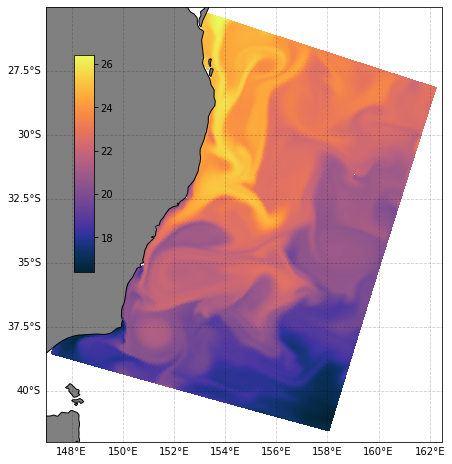

In [83]:
toPlotData=snap.temp.isel(s_rho=-1).isel(ocean_time=29)

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.thermal","vmin":15, "vmax":30, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.thermal')       
#toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
fig.colorbar(im, cax=cax) 
ax.set_title('')  fig = plt.figure(figsize=(12, 12))


In [133]:
umag.values

array([[       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.09316241, 0.09586662,
        0.        ],
       [       nan,        nan,        nan, ..., 0.08895362, 0.09202538,
        0.        ],
       ...,
       [       nan,        nan,        nan, ..., 0.22441073, 0.23009394,
        0.        ],
       [       nan,        nan,        nan, ..., 0.18763043, 0.19785789,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

[Text(0, 0.5, 'Latitude'), Text(0.5, 0, 'Longitude')]

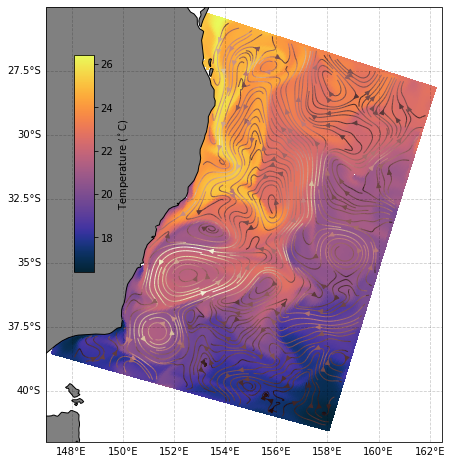

In [167]:
toPlotData=snap.temp.isel(s_rho=-1).isel(ocean_time=29)
uvel = snap.u_eastward.isel(ocean_time=29,s_rho=-1).squeeze()
vvel = snap.v_northward.isel(ocean_time=29,s_rho=-1).squeeze()
umag = np.sqrt(uvel**2+vvel**2).values

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.thermal","vmin":15, "vmax":30, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.thermal')       
sp = ax.streamplot(snap.lon_rho.values, snap.lat_rho.values, uvel.values, vvel.values,
                    color=umag,
                   linewidth=1,
                   arrowsize = 1,
                   density=4,
                    cmap='pink',
                #    color='k',
                   transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Temperature ($^\circ$C)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")



